#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 7 - Mini projects (Predicting neural activity)

The objective of the mini project is to:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [53]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [54]:
from week5.utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=fab887fe-63e1-4203-90a6-d51028a77ab4
To: /home/jupyter/NX414-Project/week5/IT_data.h5
100%|██████████| 384M/384M [00:01<00:00, 214MB/s]  


'IT_data.h5'

### Load the data

In [55]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [56]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


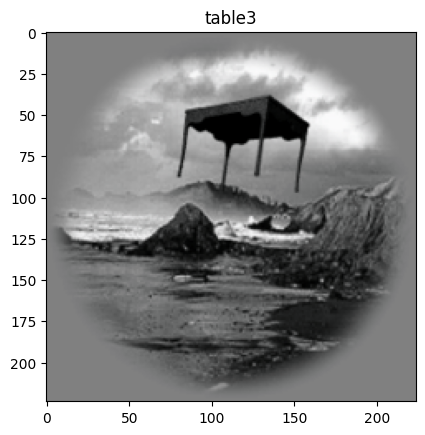

In [57]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

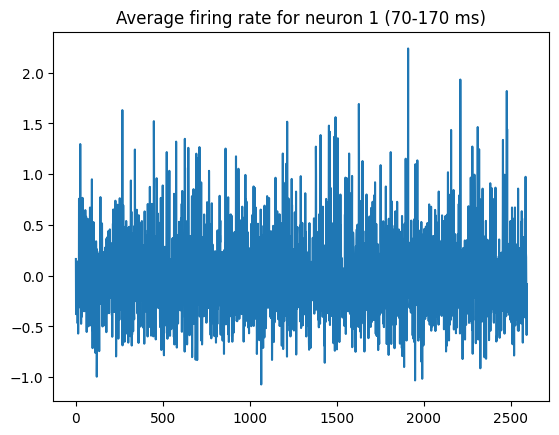

In [58]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Challenge: Develop the most accurate model for predicting IT neural activity.



Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity.

To go further we decided to seek to improve our model developed in Week 6 in order to determine the best results that the data-driven approach could bring us. 

For that purpose we used three main different approaches:  
-**Parameters tuning of the model**  
-**Architectural changes in the model**  
-**Data augmentation**

***To begin, we re-define the class and functions that we have used in week6:***

In [59]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

train_dataloader = DataLoader(stimulus_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(stimulus_test, batch_size=64, shuffle=True)

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch import flatten

from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time


class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=140450, out_features=500)
		self.relu3 = ReLU()
		self.fc2 = Linear(in_features=500, out_features=classes)
        
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# output after the second fc layer
		output=self.fc2(x)
        
		# return the output predictions
		return output
        


In [61]:
# Reload the data just for coherence
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

stimulus_train = torch.from_numpy(stimulus_train).type(torch.FloatTensor)
spikes_train=torch.from_numpy(spikes_train).type(torch.FloatTensor)
dataset_train=TensorDataset(stimulus_train,spikes_train)
train_dataloader=DataLoader(dataset_train)

stimulus_val = torch.from_numpy(stimulus_val).type(torch.FloatTensor)
spikes_val=torch.from_numpy(spikes_val).type(torch.FloatTensor)
dataset_val=TensorDataset(stimulus_val,spikes_val)
val_dataloader=DataLoader(dataset_val)

trainSteps = len(train_dataloader.dataset) #BATCH_SIZE
valSteps = len(val_dataloader.dataset) #BATCH_SIZE

In [62]:
def train(model,crit,opt,EPOCHS):
    criterion=crit
    optimizer=opt

    epoch=1 #Counter of epochs
    for e in range(0, EPOCHS):
        # set the model in training mode
        model.train()
        # initialize the total training and validation loss
        totalTrainLoss = 0
        totalValLoss = 0

        # loop over the training set
        for (x, y) in train_dataloader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # perform a forward pass and calculate the training loss
            pred = model(x)
            loss = criterion(pred, y)
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # add the loss to the total training loss so far
            totalTrainLoss += loss
        with torch.no_grad():    
            model.eval()
            # loop over the validation set
            for (x, y) in val_dataloader:
                # send the input to the device
                (x, y) = (x.to(device), y.to(device))
                # make the predictions and calculate the validation loss
                pred = model(x)
                totalValLoss += criterion(pred, y)
        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss/trainSteps
        avgValLoss = totalValLoss/valSteps
        print("Epoch {}, Avg training loss={}, Avg validation loss={}".format(epoch,avgTrainLoss,avgValLoss))
        epoch+=1

    print("Training Complete")
    return(model)
    

In [63]:
from sklearn.metrics import explained_variance_score
stimulus_val=stimulus_val.cuda()
def score(model):
    with torch.no_grad():
        pred_val=model(stimulus_val)
    exp_var=[]
    corr=[]
    for i in range(168):
        exp_var.append(explained_variance_score(spikes_val.cpu().numpy()[:,i],pred_val.cpu().detach().numpy()[:,i]))
        corr.append(np.corrcoef(spikes_val.cpu().numpy()[:,i],pred_val.cpu().detach().numpy()[:,i])[0,1])
    return(exp_var,corr)

## Tuning the loss function

First, let's start by trying to find the best loss function:

In [64]:
#Testing MSE (the one used in Week6):
# initialize the LeNet model
model = LeNet(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_MSE,corr_MSE=score(model)


Epoch 1, Avg training loss=0.13105255365371704, Avg validation loss=0.127998948097229
Epoch 2, Avg training loss=0.11835584789514542, Avg validation loss=0.11679855734109879
Epoch 3, Avg training loss=0.1084485799074173, Avg validation loss=0.11229431629180908
Epoch 4, Avg training loss=0.10054740309715271, Avg validation loss=0.11032868921756744
Epoch 5, Avg training loss=0.09183579683303833, Avg validation loss=0.10983339697122574
Epoch 6, Avg training loss=0.08148833364248276, Avg validation loss=0.11114142090082169
Epoch 7, Avg training loss=0.06993357092142105, Avg validation loss=0.11336777359247208
Epoch 8, Avg training loss=0.05823548138141632, Avg validation loss=0.11655402183532715
Epoch 9, Avg training loss=0.04744889587163925, Avg validation loss=0.11989425122737885
Epoch 10, Avg training loss=0.03851572796702385, Avg validation loss=0.12393314391374588
Training Complete


In [65]:
print('Mean explained variance with "default settings": ',round(100*np.mean(exp_var_MSE),2),'%')
print('Mean correlation with "default" settings: ',round(100*np.mean(corr_MSE),2),'%')

Mean explained variance with "default settings":  6.0 %
Mean correlation with "default" settings:  39.97 %


In [66]:
#Testing MAE loss
model = LeNet(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_MAE,corr_MAE=score(model)

Epoch 1, Avg training loss=0.26398974657058716, Avg validation loss=0.2619173526763916
Epoch 2, Avg training loss=0.2518976628780365, Avg validation loss=0.25022077560424805
Epoch 3, Avg training loss=0.24064214527606964, Avg validation loss=0.2444952130317688
Epoch 4, Avg training loss=0.23052020370960236, Avg validation loss=0.24197618663311005
Epoch 5, Avg training loss=0.2189183235168457, Avg validation loss=0.24206866323947906
Epoch 6, Avg training loss=0.20547176897525787, Avg validation loss=0.24343177676200867
Epoch 7, Avg training loss=0.190668985247612, Avg validation loss=0.2454289048910141
Epoch 8, Avg training loss=0.1759112924337387, Avg validation loss=0.24662794172763824
Epoch 9, Avg training loss=0.16298048198223114, Avg validation loss=0.248280867934227
Epoch 10, Avg training loss=0.15285229682922363, Avg validation loss=0.2489996701478958
Training Complete


In [67]:
#Testing Huber loss
model = LeNet(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_Huber,corr_Huber=score(model)

Epoch 1, Avg training loss=0.06370770931243896, Avg validation loss=0.06277427822351456
Epoch 2, Avg training loss=0.059297237545251846, Avg validation loss=0.059246666729450226
Epoch 3, Avg training loss=0.055721089243888855, Avg validation loss=0.056750502437353134
Epoch 4, Avg training loss=0.05242210626602173, Avg validation loss=0.055176328867673874
Epoch 5, Avg training loss=0.049350835382938385, Avg validation loss=0.05444108694791794
Epoch 6, Avg training loss=0.046278215944767, Avg validation loss=0.05417802929878235
Epoch 7, Avg training loss=0.042983200401067734, Avg validation loss=0.05434681475162506
Epoch 8, Avg training loss=0.039382364600896835, Avg validation loss=0.054885514080524445
Epoch 9, Avg training loss=0.03552203252911568, Avg validation loss=0.05577386915683746
Epoch 10, Avg training loss=0.03154543414711952, Avg validation loss=0.057080354541540146
Training Complete


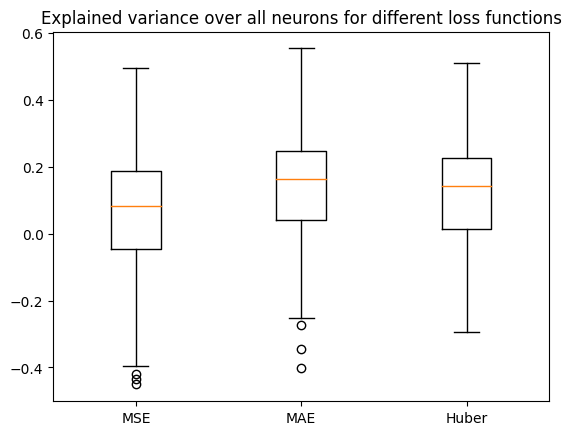

In [68]:
plt.boxplot([exp_var_MSE,exp_var_MAE,exp_var_Huber],labels=['MSE','MAE','Huber'])
plt.title('Explained variance over all neurons for different loss functions')
plt.show()

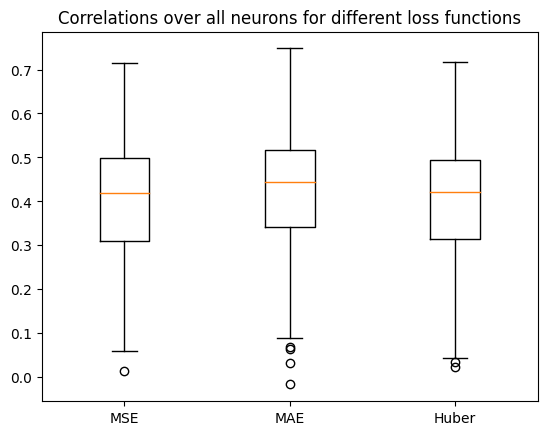

In [69]:
plt.boxplot([corr_MSE,corr_MAE,corr_Huber],labels=['MSE','MAE','Huber'])
plt.title('Correlations over all neurons for different loss functions')
plt.show()

In [70]:
print('Mean explained variance for MSE',np.mean(exp_var_MSE),'\n Mean explained variance for MAE',np.mean(exp_var_MAE),'\n Mean explained variance for Hubber loss',np.mean(exp_var_Huber))

Mean explained variance for MSE 0.059980799754460655 
 Mean explained variance for MAE 0.14788856889520371 
 Mean explained variance for Hubber loss 0.12725103894869486


Considering these results, we note that the MAE gave slightly better results. **We will then use MAE (Mean Absolute Error) loss for the following trials.**

## Tuning the optimizer

As for the loss functions, we will compare three different optimizers.

For the Adam optimizer, the recommended value for the learning rate was 0.001 but it led to poor results (constant predictions) so we adjusted it to 0.0005.

In [71]:
#Testing ADAM
model = LeNet(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
model=train(model,criterion,optimizer,10)
exp_var_Adam,corr_Adam=score(model)

Epoch 1, Avg training loss=0.2636602818965912, Avg validation loss=0.25690728425979614
Epoch 2, Avg training loss=0.2384803742170334, Avg validation loss=0.24900129437446594
Epoch 3, Avg training loss=0.2135147601366043, Avg validation loss=0.24798232316970825
Epoch 4, Avg training loss=0.196446031332016, Avg validation loss=0.2491503804922104
Epoch 5, Avg training loss=0.18396230041980743, Avg validation loss=0.24763260781764984
Epoch 6, Avg training loss=0.1748901605606079, Avg validation loss=0.24874316155910492
Epoch 7, Avg training loss=0.16750264167785645, Avg validation loss=0.24920640885829926
Epoch 8, Avg training loss=0.16197174787521362, Avg validation loss=0.24777603149414062
Epoch 9, Avg training loss=0.15753409266471863, Avg validation loss=0.24858379364013672
Epoch 10, Avg training loss=0.15350955724716187, Avg validation loss=0.24877865612506866
Training Complete


In [72]:
#Testing Adagrad
model = LeNet(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_Adagrad,corr_Adagrad=score(model)

Epoch 1, Avg training loss=0.5395877361297607, Avg validation loss=0.2620491087436676
Epoch 2, Avg training loss=0.23749302327632904, Avg validation loss=0.2520858347415924
Epoch 3, Avg training loss=0.21107721328735352, Avg validation loss=0.24919062852859497
Epoch 4, Avg training loss=0.19042380154132843, Avg validation loss=0.2504015862941742
Epoch 5, Avg training loss=0.17493422329425812, Avg validation loss=0.25233158469200134
Epoch 6, Avg training loss=0.1627892404794693, Avg validation loss=0.2533954083919525
Epoch 7, Avg training loss=0.15278050303459167, Avg validation loss=0.25648045539855957
Epoch 8, Avg training loss=0.14440952241420746, Avg validation loss=0.25672489404678345
Epoch 9, Avg training loss=0.13785488903522491, Avg validation loss=0.2583014965057373
Epoch 10, Avg training loss=0.1325661838054657, Avg validation loss=0.2600758373737335
Training Complete


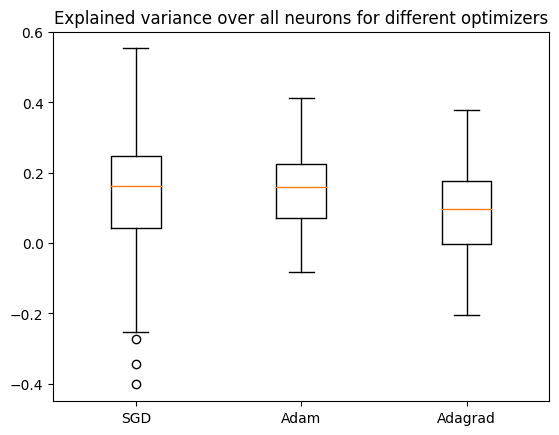

In [73]:
plt.boxplot([exp_var_MAE,exp_var_Adam,exp_var_Adagrad],labels=['SGD','Adam','Adagrad'])
plt.title('Explained variance over all neurons for different optimizers')
plt.show()

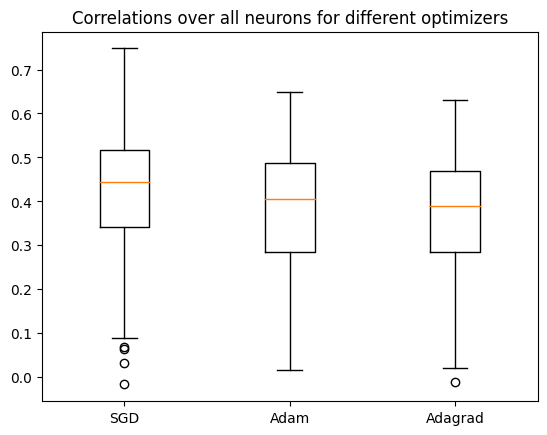

In [74]:
plt.boxplot([corr_MAE,corr_Adam,corr_Adagrad],labels=['SGD','Adam','Adagrad'])
plt.title('Correlations over all neurons for different optimizers')
plt.show()

**Since there is no significant difference between all three optimizers, we will keep using SGD in the following.**

## Adding convolution layers?

One may think that adding convolution layers may help the model capturing complex patterns. Let's try this, and add two other sets of CONV=>RELU=>MAXPOOL layers to our network.

To test this new architecture, we define a new class **LeNet4Conv**.


In [75]:
class LeNet4Conv(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet4Conv, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=20,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize third set of CONV => RELU => POOL layers
		self.conv3 = Conv2d(in_channels=20, out_channels=20,
			kernel_size=(5, 5))
		self.relu3 = ReLU()
		self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize fourth and last set of CONV => RELU => POOL layers
		self.conv4 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu4 = ReLU()
		self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=5000, out_features=500)
		self.relu5 = ReLU()
		self.fc2 = Linear(in_features=500, out_features=classes)
        
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		#and so on for the next two set of CONV => RELU => POOL layers that we added        
		x = self.conv3(x)
		x = self.relu3(x)
		x = self.maxpool3(x)
		x = self.conv4(x)
		x = self.relu4(x)
		x = self.maxpool4(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu5(x)
		# output after the second fc layer
		output=self.fc2(x)
        
		# return the output predictions
		return output

In [76]:
#Testing with 4 convolution layers
model = LeNet4Conv(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_4conv,corr_4conv=score(model)

Epoch 1, Avg training loss=0.26862895488739014, Avg validation loss=0.2720562815666199
Epoch 2, Avg training loss=0.26501283049583435, Avg validation loss=0.2671779692173004
Epoch 3, Avg training loss=0.2599072754383087, Avg validation loss=0.2602459192276001
Epoch 4, Avg training loss=0.2549373209476471, Avg validation loss=0.25492921471595764
Epoch 5, Avg training loss=0.2508034408092499, Avg validation loss=0.25083571672439575
Epoch 6, Avg training loss=0.24702969193458557, Avg validation loss=0.24741213023662567
Epoch 7, Avg training loss=0.24322517216205597, Avg validation loss=0.24434156715869904
Epoch 8, Avg training loss=0.23936247825622559, Avg validation loss=0.24113787710666656
Epoch 9, Avg training loss=0.235555961728096, Avg validation loss=0.23901210725307465
Epoch 10, Avg training loss=0.2318822592496872, Avg validation loss=0.23747757077217102
Training Complete


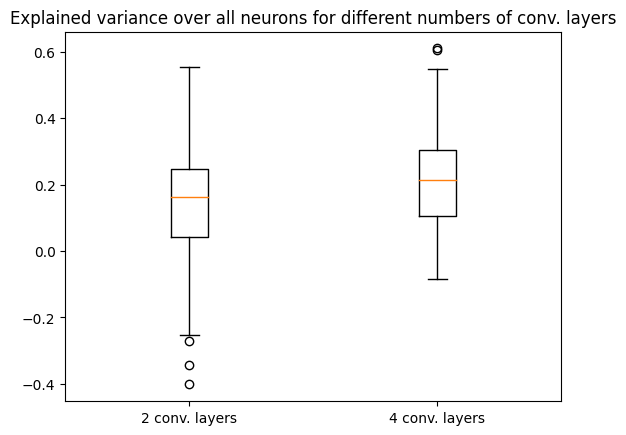

In [77]:
plt.boxplot([exp_var_MAE,exp_var_4conv],labels=['2 conv. layers','4 conv. layers'])
plt.title('Explained variance over all neurons for different numbers of conv. layers')
plt.show()

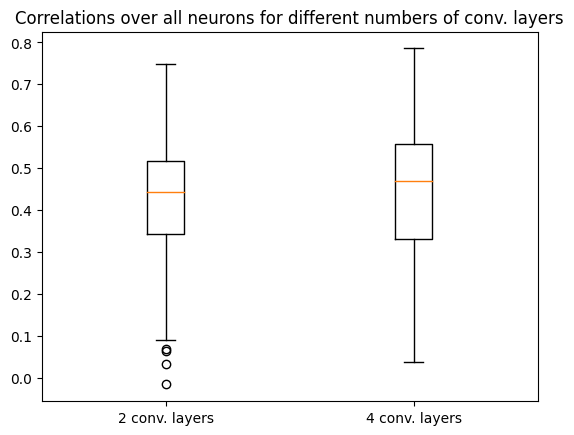

In [78]:
plt.boxplot([corr_MAE,corr_4conv],labels=['2 conv. layers','4 conv. layers'])
plt.title('Correlations over all neurons for different numbers of conv. layers')
plt.show()

**When compared to the best previous model (with MAE and SGD), we see no major improvement, only a slight increase, mainly in explained variance.**

## Adding fully connected layers ?

Part of the decision made by the model is done in the fully connected layers that are at the end of the network, and allows to produce the multi-regression output. In the following we then try to add two other fully connected layers, in order to see if it improves the results.

Let's define a new class **LeNet4Fc**.

In [79]:
class LeNet4Fc(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet4Fc, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# 4 sets of FC => RELU layers
		self.fc1 = Linear(in_features=140450, out_features=1000)
		self.relu3 = ReLU()
		self.fc2 = Linear(in_features=1000, out_features=1000)
		self.relu4 = ReLU()
		self.fc3 = Linear(in_features=1000, out_features=500)
		self.relu5 = ReLU()
		self.fc4 = Linear(in_features=500, out_features=classes)
        
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		#We add our two new fc layers
		x = self.fc2(x)
		x = self.relu4(x)
		x = self.fc3(x)
		x = self.relu5(x)        
		# output after the second fc layer
		output=self.fc4(x)
        
		# return the output predictions
		return output

In [80]:
#Testing with 4 FC layers
model = LeNet4Fc(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_4fc,corr_4fc=score(model)

Epoch 1, Avg training loss=0.2668296694755554, Avg validation loss=0.2686406970024109
Epoch 2, Avg training loss=0.2612663805484772, Avg validation loss=0.2623143494129181
Epoch 3, Avg training loss=0.2556939423084259, Avg validation loss=0.2566840648651123
Epoch 4, Avg training loss=0.25065118074417114, Avg validation loss=0.2522895336151123
Epoch 5, Avg training loss=0.24552926421165466, Avg validation loss=0.24820338189601898
Epoch 6, Avg training loss=0.23997537791728973, Avg validation loss=0.24471670389175415
Epoch 7, Avg training loss=0.234264075756073, Avg validation loss=0.24185344576835632
Epoch 8, Avg training loss=0.22819648683071136, Avg validation loss=0.24037782847881317
Epoch 9, Avg training loss=0.22136805951595306, Avg validation loss=0.2396509349346161
Epoch 10, Avg training loss=0.2132670134305954, Avg validation loss=0.239462211728096
Training Complete


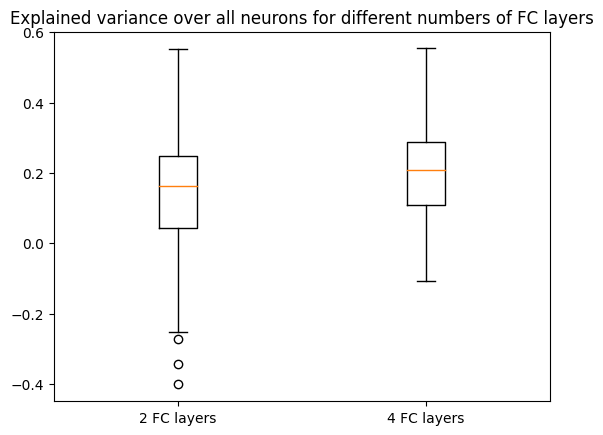

In [81]:
plt.boxplot([exp_var_MAE,exp_var_4fc],labels=['2 FC layers','4 FC layers'])
plt.title('Explained variance over all neurons for different numbers of FC layers')
plt.show()

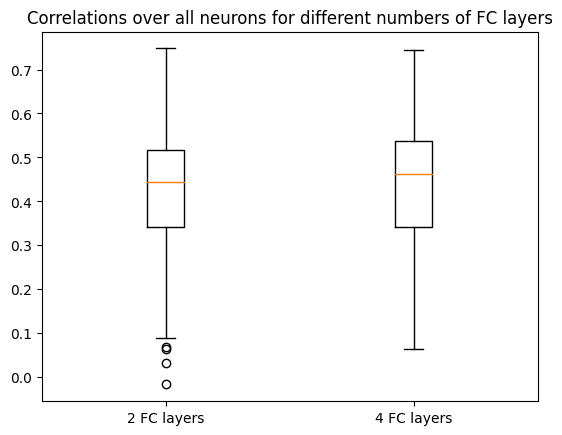

In [82]:
plt.boxplot([corr_MAE,corr_4fc],labels=['2 FC layers','4 FC layers'])
plt.title('Correlations over all neurons for different numbers of FC layers')
plt.show()

**Again here, we see that adding FC layers only allows a slight improvement of the results**

## Doing both ?


In the following we try a new model with 4 sets of convoluntional layers and 4 FC layers (instead of the 2+2 initially used in LeNet class). 
To do so, we define a new class **LeNet44**.

In [83]:
class LeNet44(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet44, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=20,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize third set of CONV => RELU => POOL layers
		self.conv3 = Conv2d(in_channels=20, out_channels=20,
			kernel_size=(5, 5))
		self.relu3 = ReLU()
		self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize fourth and last set of CONV => RELU => POOL layers
		self.conv4 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu4 = ReLU()
		self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# 4 set of FC => RELU layers
		self.fc1 = Linear(in_features=5000, out_features=1000)
		self.relu5 = ReLU()
		self.fc2 = Linear(in_features=1000, out_features=1000)
		self.relu6 = ReLU()
		self.fc3 = Linear(in_features=1000, out_features=500)
		self.relu7 = ReLU()
		self.fc4 = Linear(in_features=500, out_features=classes)
        
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		#and so on for the next two set of CONV => RELU => POOL layers that we added        
		x = self.conv3(x)
		x = self.relu3(x)
		x = self.maxpool3(x)
		x = self.conv4(x)
		x = self.relu4(x)
		x = self.maxpool4(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu5(x)
		x = self.fc2(x)
		x = self.relu6(x)
		x = self.fc3(x)
		x = self.relu7(x)
		# output after the second fc layer
		output=self.fc4(x)
        
		# return the output predictions
		return output

In [84]:
#Testing with 4 convolution and FC layers
model = LeNet44(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_44,corr_44=score(model)

Epoch 1, Avg training loss=0.2698560953140259, Avg validation loss=0.2746393084526062
Epoch 2, Avg training loss=0.2685571610927582, Avg validation loss=0.27376317977905273
Epoch 3, Avg training loss=0.26799511909484863, Avg validation loss=0.2733113765716553
Epoch 4, Avg training loss=0.26765745878219604, Avg validation loss=0.2729445695877075
Epoch 5, Avg training loss=0.2672412395477295, Avg validation loss=0.2722124457359314
Epoch 6, Avg training loss=0.266099214553833, Avg validation loss=0.269817978143692
Epoch 7, Avg training loss=0.26307034492492676, Avg validation loss=0.264676034450531
Epoch 8, Avg training loss=0.2593941390514374, Avg validation loss=0.2605765461921692
Epoch 9, Avg training loss=0.2566041052341461, Avg validation loss=0.2578412592411041
Epoch 10, Avg training loss=0.2541319727897644, Avg validation loss=0.2555590569972992
Training Complete


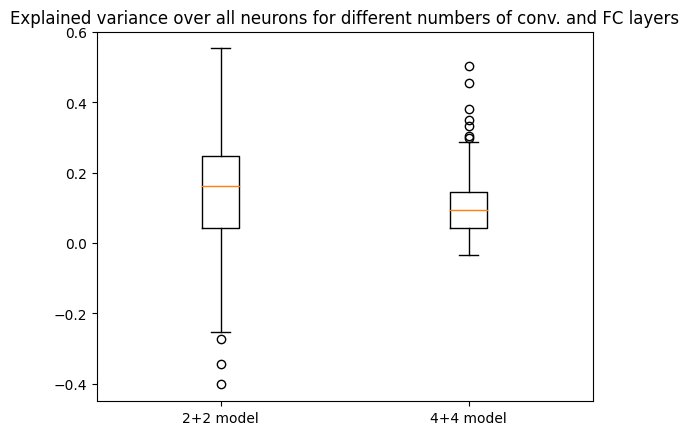

In [85]:
plt.boxplot([exp_var_MAE,exp_var_44],labels=['2+2 model','4+4 model'])
plt.title('Explained variance over all neurons for different numbers of conv. and FC layers')
plt.show()

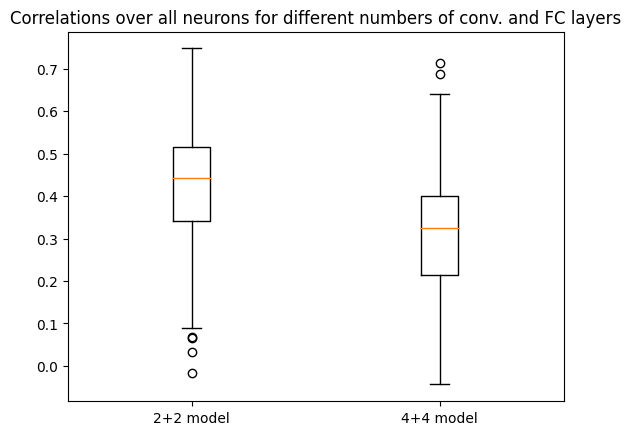

In [86]:
plt.boxplot([corr_MAE,corr_44],labels=['2+2 model','4+4 model'])
plt.title('Correlations over all neurons for different numbers of conv. and FC layers')
plt.show()

**Surprisingly, the model is not better according to our two metrics. It only decreased the dispersion of the results. But with lower medians.**

## Best model

According to the previous results, we decide to keep the model that gave the best performances (with only a slight advantage on some other models), that is **the model with MAE loss, SGD optimizer, 2 conv+Relu+Maxpool layers and 4 FC layers**.

In [87]:
print('Mean explained variance with best settings: ',round(100*np.mean(exp_var_4fc),2),'%')
print('Mean correlation with best settings: ',round(100*np.mean(corr_4fc),2),'%')

Mean explained variance with best settings:  20.52 %
Mean correlation with best settings:  43.61 %


**The explained variance went from around 2% with first shallow CNN model we developped to around 20% with the one we kept after tuning the paramters and trying different architectures. However, there is still a strong dispersion of the result with few negative values.**

## Data augmentation

One can note that during most of the training phases previously performed, the models often tend to decrease the training loss but not that much the validation loss. **This may be a sign of over-fitting relative to the training data.**. 

To tackle this issue, we try to increase the size of the trainins set, by performing data augmentation. Among the well known data augmentation techniques, we are going to perform 3 random rotations for each image. This choice was made since it seems to be the kind of variation that exist from one image to another in our sets of images. Each of these rotations will be associated with the same activations as the original image. ***Note that this rely on the assumption that the neurons of the monkey would have the same response for these rotated images, which may be incorrect!***

In [114]:
# Reload the data just for coherence
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

stimulus_train = torch.from_numpy(stimulus_train).type(torch.FloatTensor)
spikes_train=torch.from_numpy(spikes_train).type(torch.FloatTensor)


stimulus_val = torch.from_numpy(stimulus_val).type(torch.FloatTensor)
spikes_val=torch.from_numpy(spikes_val).type(torch.FloatTensor)

stimulus_val=stimulus_val.cuda()

In [96]:
import torchvision.transforms as T
torch.manual_seed(0)

We just re-define a visualization function to check that our transformations properly applied:

In [97]:
def visualize(tensor_image):
    img=tensor_image.numpy()
    img = np.transpose(img,[1,2,0])
    normalize_mean=[0.485, 0.456, 0.406]
    normalize_std=[0.229, 0.224, 0.225]
    img = (img*normalize_std + normalize_mean) * 255
    plt.imshow(img.astype(np.uint8),cmap='gray')
    plt.show()

**We now apply a triple rotation to every image of the training set, increasing by a factor 4 its size:**

In [98]:
imgs=[]
spikes=[]
for i in range(2592):
    rotater = T.RandomRotation(degrees=(0, 180))
    imgs.append(stimulus_train[i])
    rotated_imgs = [rotater(stimulus_train[i]) for _ in range(3)]
    imgs=imgs+rotated_imgs
    spikes_i=[]
    for i in range(4):
        spikes_i.append(spikes_train[i])
    spikes=spikes+spikes_i
    
stimulus_train=torch.stack(imgs)
spikes_train=torch.stack(spikes)

Let's have a look at the first 4 images of the new training set, that are all rotations from the first one of the original training set.

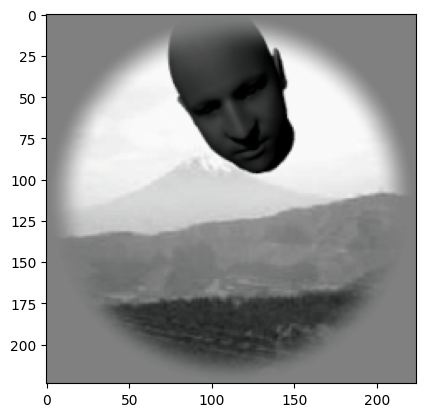

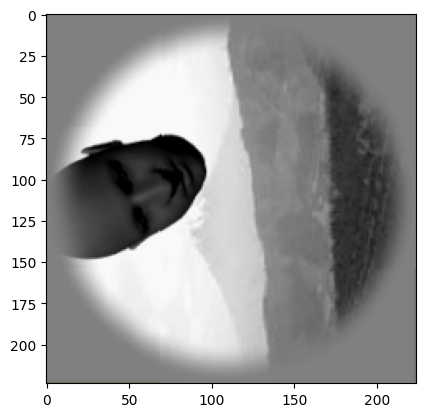

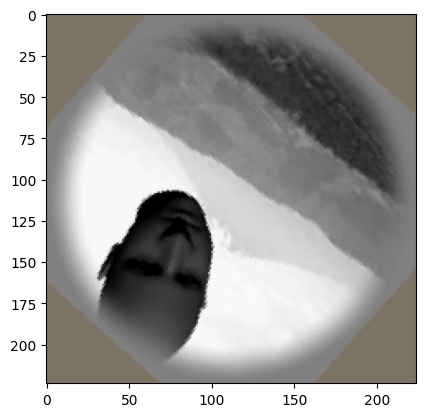

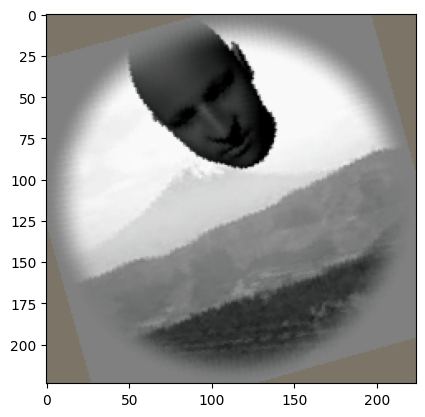

In [99]:
for i in range(4):
    visualize(stimulus_train[i])

**Let's train the best model we have on this extended training set:**

In [100]:
dataset_train=TensorDataset(stimulus_train,spikes_train)
train_dataloader=DataLoader(dataset_train)
dataset_val=TensorDataset(stimulus_val,spikes_val)
val_dataloader=DataLoader(dataset_val)

trainSteps = len(train_dataloader.dataset) #BATCH_SIZE
valSteps = len(val_dataloader.dataset) #BATCH_SIZE

In [101]:
#Using the 4 FC layers model we kept
model = LeNet4Fc(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_4rotations,corr_4rotations=score(model)

Epoch 1, Avg training loss=0.1694757640361786, Avg validation loss=0.40775278210639954
Epoch 2, Avg training loss=0.14179782569408417, Avg validation loss=0.41397935152053833
Epoch 3, Avg training loss=0.1361696571111679, Avg validation loss=0.4246983230113983
Epoch 4, Avg training loss=0.13315445184707642, Avg validation loss=0.41671377420425415
Epoch 5, Avg training loss=0.1309768706560135, Avg validation loss=0.41223999857902527
Epoch 7, Avg training loss=0.12715163826942444, Avg validation loss=0.3940841257572174
Epoch 8, Avg training loss=0.12588049471378326, Avg validation loss=0.4074847400188446
Epoch 9, Avg training loss=0.12489555776119232, Avg validation loss=0.4010457396507263
Epoch 10, Avg training loss=0.12440159916877747, Avg validation loss=0.4030821919441223
Training Complete


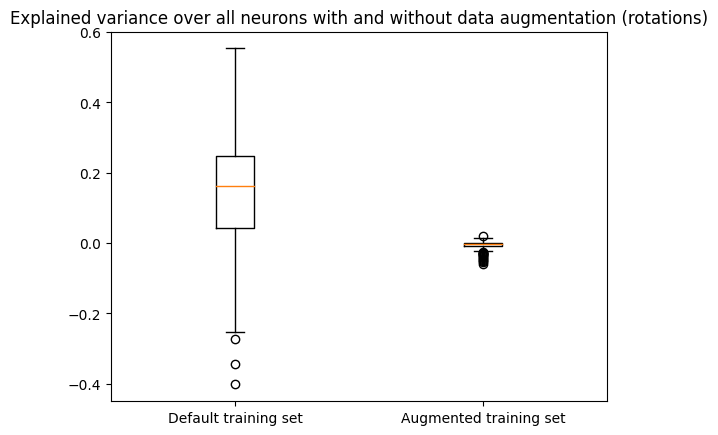

In [102]:
plt.boxplot([exp_var_MAE,exp_var_4rotations],labels=['Default training set','Augmented training set'])
plt.title('Explained variance over all neurons with and without data augmentation (rotations)')
plt.show()

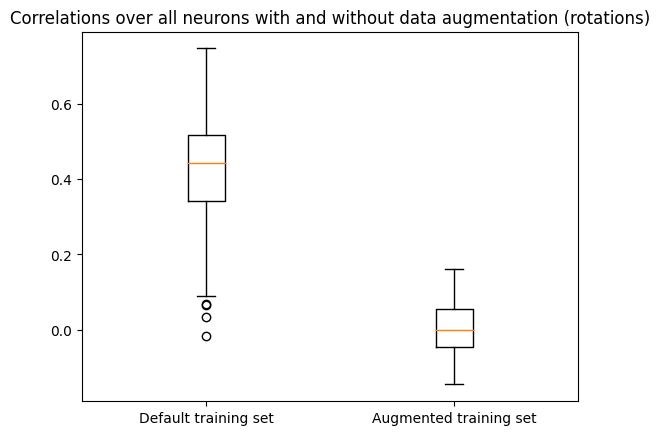

In [103]:
plt.boxplot([corr_MAE,corr_4rotations],labels=['Default training set','Augmented training set'])
plt.title('Correlations over all neurons with and without data augmentation (rotations)')
plt.show()

**We can immediatly see that training the model on the rotation-augmented dataset did not improve the results.** It actually gave significantly lower median values for both metrics. However, it decreased the dispersion of the results across neurons. 

This poor results may be linked to the fact that the rotations generate "blank" corners sometimes, that my disturb the model in capturing the appropriate patterns. Also, rotations may be irrelevant with respect to the validation set images. Or, as mentionned at the beginning of this section, it simply means that the monkey's neurons tend to fire differently with rotated images, which implies that our data augmention procedure is incorrect.

## Another data augmentation


Let's try another data augmentation technique, that modify less the images, in the sense that it does generate blank corners. **These are the vertical and horizontal flip transformations.** We process exactly as before:

In [107]:
# Reload the data just for coherence
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

stimulus_train = torch.from_numpy(stimulus_train).type(torch.FloatTensor)
spikes_train=torch.from_numpy(spikes_train).type(torch.FloatTensor)


stimulus_val = torch.from_numpy(stimulus_val).type(torch.FloatTensor)
spikes_val=torch.from_numpy(spikes_val).type(torch.FloatTensor)


stimulus_val=stimulus_val.cuda()


In [108]:
imgs=[]
spikes=[]
for i in range(2592):
    hflipper = T.RandomHorizontalFlip(p=1)
    vflipper = T.RandomVerticalFlip(p=1)
    imgs.append(stimulus_train[i])
    flipped_imgs = [hflipper(stimulus_train[i]),vflipper(stimulus_train[i])]
    imgs=imgs+flipped_imgs
    spikes_i=[]
    for i in range(3):
        spikes_i.append(spikes_train[i])
    spikes=spikes+spikes_i
    
stimulus_train=torch.stack(imgs)
spikes_train=torch.stack(spikes)


Let's have a look at the new 3 first images (the original first one and its two flipped versions):

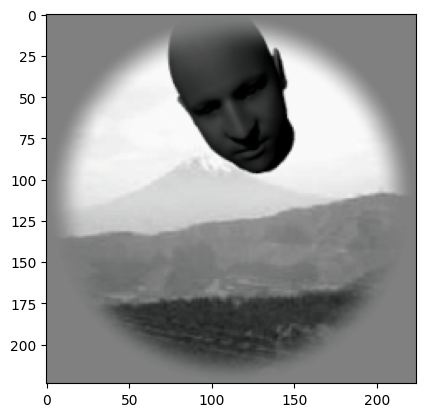

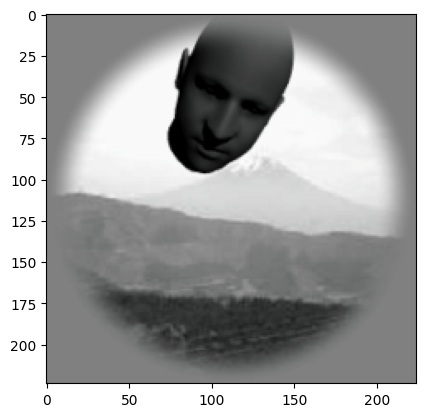

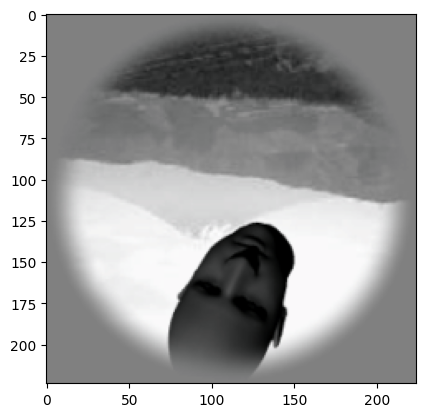

In [109]:
for i in range(3):
    visualize(stimulus_train[i])

We train our best model on this new training set:

In [110]:
dataset_train=TensorDataset(stimulus_train,spikes_train)
train_dataloader=DataLoader(dataset_train)
dataset_val=TensorDataset(stimulus_val,spikes_val)
val_dataloader=DataLoader(dataset_val)

trainSteps = len(train_dataloader.dataset) #BATCH_SIZE
valSteps = len(val_dataloader.dataset) #BATCH_SIZE

In [111]:
#Using the 4 FC layers model we kept
model = LeNet4Fc(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)
exp_var_flips,corr_flips=score(model)

Epoch 1, Avg training loss=0.176577627658844, Avg validation loss=0.3232298195362091
Epoch 2, Avg training loss=0.16598135232925415, Avg validation loss=0.32695671916007996
Epoch 3, Avg training loss=0.16261833906173706, Avg validation loss=0.32521525025367737
Epoch 4, Avg training loss=0.15941135585308075, Avg validation loss=0.32336798310279846
Epoch 5, Avg training loss=0.15582482516765594, Avg validation loss=0.32545483112335205
Epoch 6, Avg training loss=0.15165074169635773, Avg validation loss=0.3257364332675934
Epoch 7, Avg training loss=0.14598996937274933, Avg validation loss=0.3131074011325836
Epoch 8, Avg training loss=0.13459885120391846, Avg validation loss=0.3332330286502838
Epoch 9, Avg training loss=0.10153743624687195, Avg validation loss=0.37067607045173645
Epoch 10, Avg training loss=0.06293406337499619, Avg validation loss=0.3600517511367798
Training Complete


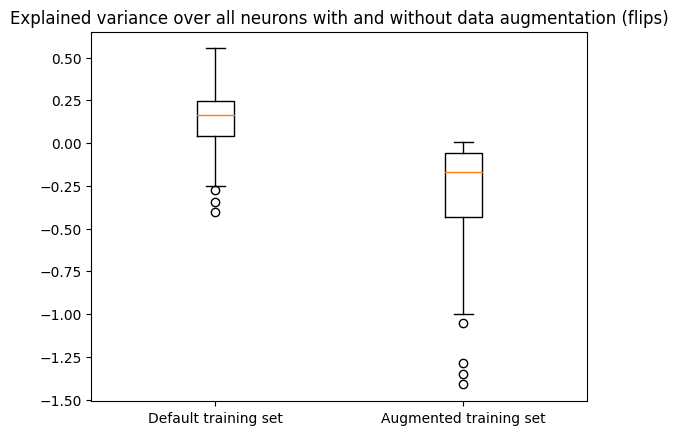

In [112]:
plt.boxplot([exp_var_MAE,exp_var_flips],labels=['Default training set','Augmented training set'])
plt.title('Explained variance over all neurons with and without data augmentation (flips)')
plt.show()

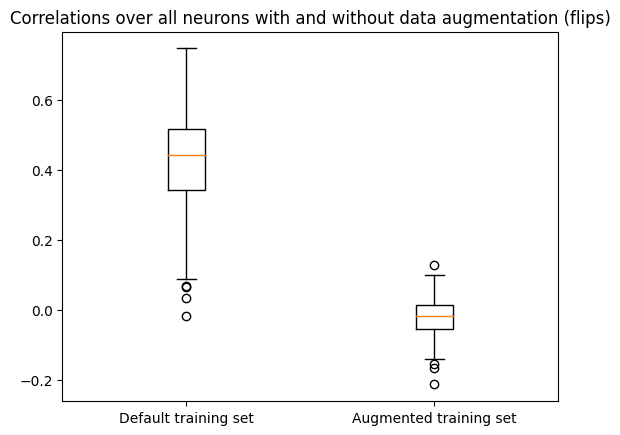

In [113]:
plt.boxplot([corr_MAE,corr_flips],labels=['Default training set','Augmented training set'])
plt.title('Correlations over all neurons with and without data augmentation (flips)')
plt.show()

**Again, the results are better when the model is trained with the original dataset.** Thus, the assumption that the neurons of the monkey would have the same response for the transformed images added to the original dataset, is likely to be incorrect.

## Conclusions - best model export

Through all these results, it appeared that the best model according to our metrics is the one with MAE loss, SGD optimizer, 2 conv+Relu+Maxpool layers and 4 FC layers, **when it is trained on the original training set**. We are now going to save the corresponging model.

We make sure to train it on the original training set:

In [116]:
# Reload the data just for coherence
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

stimulus_train = torch.from_numpy(stimulus_train).type(torch.FloatTensor)
spikes_train=torch.from_numpy(spikes_train).type(torch.FloatTensor)
dataset_train=TensorDataset(stimulus_train,spikes_train)
train_dataloader=DataLoader(dataset_train)

stimulus_val = torch.from_numpy(stimulus_val).type(torch.FloatTensor)
spikes_val=torch.from_numpy(spikes_val).type(torch.FloatTensor)
dataset_val=TensorDataset(stimulus_val,spikes_val)
val_dataloader=DataLoader(dataset_val)

trainSteps = len(train_dataloader.dataset) #BATCH_SIZE
valSteps = len(val_dataloader.dataset) #BATCH_SIZE

stimulus_val=stimulus_val.cuda()

We perform the training:

In [117]:
#Creating the model once again
model = LeNet4Fc(numChannels=3,classes=168).to(device)
# initialize our optimizer and loss function
criterion = torch.nn.L1Loss() #We kept MAE loss
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model=train(model,criterion,optimizer,10)

Epoch 1, Avg training loss=0.26762405037879944, Avg validation loss=0.27005448937416077
Epoch 2, Avg training loss=0.26214584708213806, Avg validation loss=0.2629927694797516
Epoch 3, Avg training loss=0.2560683488845825, Avg validation loss=0.2560851573944092
Epoch 4, Avg training loss=0.25065574049949646, Avg validation loss=0.25118154287338257
Epoch 5, Avg training loss=0.2452709972858429, Avg validation loss=0.24719858169555664
Epoch 6, Avg training loss=0.23977181315422058, Avg validation loss=0.24411797523498535
Epoch 7, Avg training loss=0.23444950580596924, Avg validation loss=0.24164491891860962
Epoch 8, Avg training loss=0.22882936894893646, Avg validation loss=0.2401195615530014
Epoch 9, Avg training loss=0.2225048840045929, Avg validation loss=0.23939228057861328
Epoch 10, Avg training loss=0.21518012881278992, Avg validation loss=0.2394338995218277
Training Complete


In [119]:
torch.save(model.state_dict(),'best_model.pth')

End of this notebook, please see test.ipynb to see an example for loading and running the model.